In [1]:
!python -V

Python 3.9.7


In [2]:
import pandas as pd

In [3]:
import pickle

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import warnings
from sklearn.metrics import mean_squared_error

In [6]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyctaxi_experiments")

warnings.filterwarnings("ignore")


2022/06/24 15:50:49 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2022/06/24 15:50:49 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Running upgrade  -> 451aebb31d03, add metric step
INFO  [alembic.runtime.migration] Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
INFO  [alembic.runtime.migration] Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
INFO  [alembic.runtime.migration] Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
INFO  [alembic.runtime.migration] Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
INFO  [alembic.runtime.migration] Running upgrade 7ac759974ad8 -> 89d4b8295536, create latest metrics table
INFO  [89d4b8295536_create_latest_metrics_table_py] Migration complete!
INFO  

In [7]:
df = pd.read_parquet('./data/2021/green_tripdata_2021-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [8]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

9.838799799829435

In [9]:
plt.style.use("seaborn-dark")

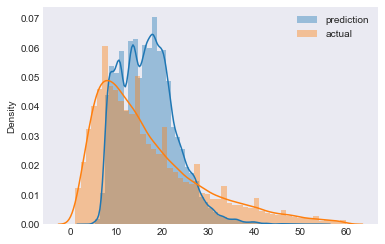

In [10]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend();

In [11]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)
    
        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [12]:
df_train = read_dataframe('./data/2021/green_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/2021/green_tripdata_2021-02.parquet')

In [13]:
len(df_train), len(df_val)

(73908, 61921)

In [14]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [15]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [16]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [17]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

7.75871520559622

In [18]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [19]:
# Save the model as an artifact

with mlflow.start_run():
    mlflow.set_tag("developer","Andrew")
    mlflow.log_param("train-data-path","./data/2021/green_tripdata_2021-01.parquet")
    mlflow.log_param("valid-data-path","./data/2021/green_tripdata_2021-02.parquet")
    lr = Lasso(0.01)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse",rmse )
    mlflow.log_artifact(local_path="models/lin_reg.bin",artifact_path="models_pickle")


### Setting up hyperparameter tunning tracking with MLFlow

In [20]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope 

In [22]:
train = xgb.DMatrix(X_train,label=y_train)
valid = xgb.DMatrix(X_val,label=y_val)

In [21]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("Model","xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain =train,
            num_boost_round=1000,
            evals=[(valid,"validation")],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val,y_pred,squared=False)
        mlflow.log_metric("rmse",rmse)
    return{'loss':rmse,'status':STATUS_OK} # SIGNAL FOR SUCCESSFUL OPTIMIZATION

In [23]:
search_space = {
    'max_depth' : scope.int(hp.quniform('max_depth',4,100,1)),
    'learning_rate' : hp.loguniform('learning_rate',-3,0), # exp(-3) and exp(0)
    'reg_alpha' : hp.loguniform('reg_alpha',-5,-1), 
    'reg_lambda' : hp.loguniform('reg_lambda',-6,-1),
    'min_child_weight': hp.loguniform('min_child_weight',-1,3),
    'objective' : 'reg:linear',
    'seed' : 42, # Assign SEED
    #'tree_method' : 'gpu_hist' # Optional : use GPU

}


# Create a best_result variable


#best_result = fmin(
#    fn=objective,
#    space=search_space,
#    algo=tpe.suggest,
#    max_evals=50,
#    trials=Trials()
#)


Where `hp.log_uniform` returns a value according to `exp(uniform(low,high))` So the return is uniformly distributed.


### Training an Xgboost model with the best params obtained by Mlflow

In [24]:

best_params = {
    'learning_rate': 0.09585355369315604,
    'max_depth': 30,
    'min_child_weight': 1.060597050922164,
    'objective': 'reg:linear',
    'reg_alpha': 0.018060244040060163,
    'reg_lambda': 0.011658731377413597,
    'seed': 42
}

mlflow.xgboost.autolog()

booster = xgb.train(
    params=best_params,
    dtrain =train,
    num_boost_round=1000,
    evals=[(valid,"validation")],
    early_stopping_rounds=50
)

2022/06/24 15:50:58 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '9a7a897cab5c45afaed91f396d16f8c1', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow


[15:50:58] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:19.48425
[1]	validation-rmse:17.95634
[2]	validation-rmse:16.59114
[3]	validation-rmse:15.37412
[4]	validation-rmse:14.29011
[5]	validation-rmse:13.32800
[6]	validation-rmse:12.47570
[7]	validation-rmse:11.72140
[8]	validation-rmse:11.05888
[9]	validation-rmse:10.47583
[10]	validation-rmse:9.96483
[11]	validation-rmse:9.51784
[12]	validation-rmse:9.12620
[13]	validation-rmse:8.78522
[14]	validation-rmse:8.49037
[15]	validation-rmse:8.23332
[16]	validation-rmse:8.01179
[17]	validation-rmse:7.81822
[18]	validation-rmse:7.65209
[19]	validation-rmse:7.50743
[20]	validation-rmse:7.38235
[21]	validation-rmse:7.27382
[22]	validation-rmse:7.17865
[23]	validation-rmse:7.09606
[24]	validation-rmse:7.02481
[25]	validation-rmse:6.96336
[26]	validation-rmse:6.91001
[27]	validation-rmse:6.86273
[28]	validation-rmse:6.82111
[29]	validation-rmse:6.78450
[30]	valida

2022/06/24 15:52:25 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.


#### 2.4 Model Management 

Experiment tracking is the process of saving all experiment related information that you care about for every experiment you run.   



![alt](https://i0.wp.com/neptune.ai/wp-content/uploads/MLOps_cycle.jpg?resize=1024%2C576&ssl=1)

**Problems** with tradicional approach:
- Error Prone : Files and directories are manually created (For many models it's even more confusing)
- No versioning 
- No model lineage : We don't know what hyper-parameters where used.

In [33]:
mlflow.xgboost.autolog(disable=True)

In [36]:
with mlflow.start_run():
    train = xgb.DMatrix(X_train,label = y_train)
    valid = xgb.DMatrix(X_val,label = y_val)
    

    best_params = {
        'learning_rate': 0.09585355369315604,
        'max_depth': 30,
        'min_child_weight': 1.060597050922164,
        'objective': 'reg:linear',
        'reg_alpha': 0.018060244040060163,
        'reg_lambda': 0.011658731377413597,
        'seed': 42
    }
    
    mlflow.log_params(best_params) # Log from current run
    
    boost = xgb.train(
        params=best_params,
        dtrain= train,
        num_boost_round = 1000,
        evals = [(valid,"validation")],
        early_stopping_rounds = 50,
    )
    
    y_pred = booster.predict(valid)
    rmse = mean_squared_error(y_val,y_pred,squared=False)
    mlflow.log_metric("rmse",rmse)
    
    with open("models/preprocessor.b", "wb") as f_out:
        pickle.dump(dv, f_out)
    mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

    mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")


    

[16:59:42] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:19.48425
[1]	validation-rmse:17.95634
[2]	validation-rmse:16.59114
[3]	validation-rmse:15.37412
[4]	validation-rmse:14.29011
[5]	validation-rmse:13.32800
[6]	validation-rmse:12.47570
[7]	validation-rmse:11.72140
[8]	validation-rmse:11.05888
[9]	validation-rmse:10.47583
[10]	validation-rmse:9.96483
[11]	validation-rmse:9.51784
[12]	validation-rmse:9.12620
[13]	validation-rmse:8.78522
[14]	validation-rmse:8.49037
[15]	validation-rmse:8.23332
[16]	validation-rmse:8.01179
[17]	validation-rmse:7.81822
[18]	validation-rmse:7.65209
[19]	validation-rmse:7.50743
[20]	validation-rmse:7.38235
[21]	validation-rmse:7.27382
[22]	validation-rmse:7.17865
[23]	validation-rmse:7.09606
[24]	validation-rmse:7.02481
[25]	validation-rmse:6.96336
[26]	validation-rmse:6.91001
[27]	validation-rmse:6.86273
[28]	validation-rmse:6.82111
[29]	validation-rmse:6.78450
[30]	valida

### 2.5 Model Registry



### Motivation
- Tracking changes , registry models with MLFlow
- Wondering what has changed ?
- Improving communication.
- Only list what models are production Ready
- Add CI/CD Code.




